# Example 3: Clustering Analysis

### Import Libraries and Install Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

### Load Data

In [2]:
# Read the TSV file
df = pd.read_csv('Filtered_Diff_Exp.tsv', sep='\t')

# Let's look at the first few rows and basic information about our dataset
print("First few rows of the dataset:")
print(df.head())
print("\nDataset information:")
print(df.info())

First few rows of the dataset:
  feature_ids  Ath_WT_R1_expression  Ath_WT_R2_expression  \
0   AT3G14770              5.019769              4.945506   
1   AT4G12460              1.152617              0.409854   
2   AT1G68790              1.172865              1.135914   
3   AT5G16780              1.133932              0.777333   
4   AT3G05130              1.702084              1.425840   

   Ath_hy5_R1_expression  Ath_hy5_R2_expression  
0               3.050257               3.115209  
1               2.701273               2.982812  
2               3.096043               3.458751  
3               3.527632               4.079876  
4               3.871323               3.896601  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   feature_ids            612 non-null    object 
 1   Ath_WT_R1_expre

### Clustering Analysis

In [3]:
# Calculate mean expression for wild type (WT) and hy5 mutant
df['WT_mean'] = df[['Ath_WT_R1_expression', 'Ath_WT_R2_expression']].mean(axis=1)
df['hy5_mean'] = df[['Ath_hy5_R1_expression', 'Ath_hy5_R2_expression']].mean(axis=1)

# Create a new dataframe with just the mean values
expression_data = df[['feature_ids', 'WT_mean', 'hy5_mean']]

print("First few rows with mean expression values:")
print(expression_data.head())

First few rows with mean expression values:
  feature_ids   WT_mean  hy5_mean
0   AT3G14770  4.982637  3.082733
1   AT4G12460  0.781235  2.842043
2   AT1G68790  1.154389  3.277397
3   AT5G16780  0.955633  3.803754
4   AT3G05130  1.563962  3.883962


Raw Expression Data:

-   Each row shows a unique Arabidopsis gene (e.g., AT3G14770)
-   WT_mean shows average expression in normal plants
-   hy5_mean shows average expression in the mutant
-   Looking at AT3G14770: expression decreases in mutant (4.98 → 3.08)
-   Looking at AT4G12460: expression increases in mutant (0.78 → 2.84)

In [4]:
# Extract features for clustering (excluding gene IDs)
X = expression_data[['WT_mean', 'hy5_mean']].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of scaled data:", X_scaled.shape)
print("\nFirst few rows of scaled data:")
print(X_scaled[:5])

Shape of scaled data: (612, 2)

First few rows of scaled data:
[[ 1.04312184 -0.35210941]
 [-0.69262915 -0.48487966]
 [-0.53846578 -0.24472823]
 [-0.62057917  0.04562283]
 [-0.36925646  0.08986728]]


Scaled Data:

-   Shape (612, 2) means we have 612 genes with 2 measurements each
-   Data has been standardized (centered and scaled) for clustering
-   Values are now in standard deviations from the mean
-   Positive values = above average expression
-   Negative values = below average expression
-   Example: First gene has above-average WT expression (1.04) but below-average hy5 expression (-0.35)

The scaling step is crucial because it puts all measurements on the same scale, making the clustering analysis more reliable and interpretable.

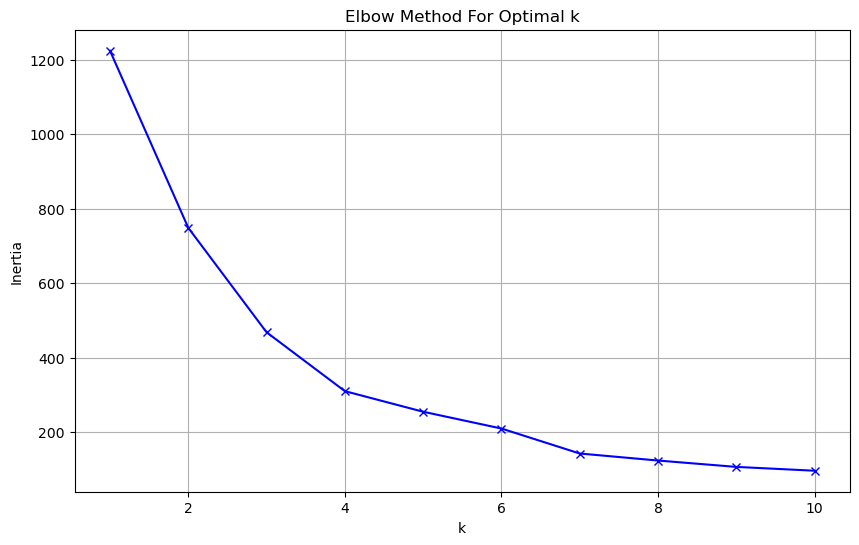

In [5]:
# Calculate inertia for different numbers of clusters
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

The elbow method plot shows how the inertia (within-cluster sum of squares) changes as we increase the number of clusters (k). Think of inertia as a measure of how spread out the data points are within their assigned clusters - lower inertia means the clusters are more compact and well-defined.
In this plot, we can see a sharp bend (the "elbow") around k=3 or k=4. This bend is significant because:

Before the elbow (k=1 to k=3), adding more clusters dramatically reduces the inertia. This tells us that each additional cluster is providing a substantial improvement in explaining the data's structure.
After the elbow (k>4), the line starts to flatten out. Adding more clusters yields diminishing returns - we're not getting as much benefit from splitting the data further.

Based on this visualization, I would recommend using k=4 clusters for our analysis. Here's why:

It's right at the elbow point where we get good cluster separation
The inertia has stabilized enough to suggest we've captured the main patterns
With 4 clusters, we'll likely be able to interpret meaningful biological differences between groups of genes

In [6]:
# Create a copy of the data first
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)         
expression_data = expression_data.copy()
expression_data['Cluster'] = clusters
print("Number of genes in each cluster:")
print(expression_data['Cluster'].value_counts())

Number of genes in each cluster:
Cluster
0    295
1    177
2    105
3     35
Name: count, dtype: int64


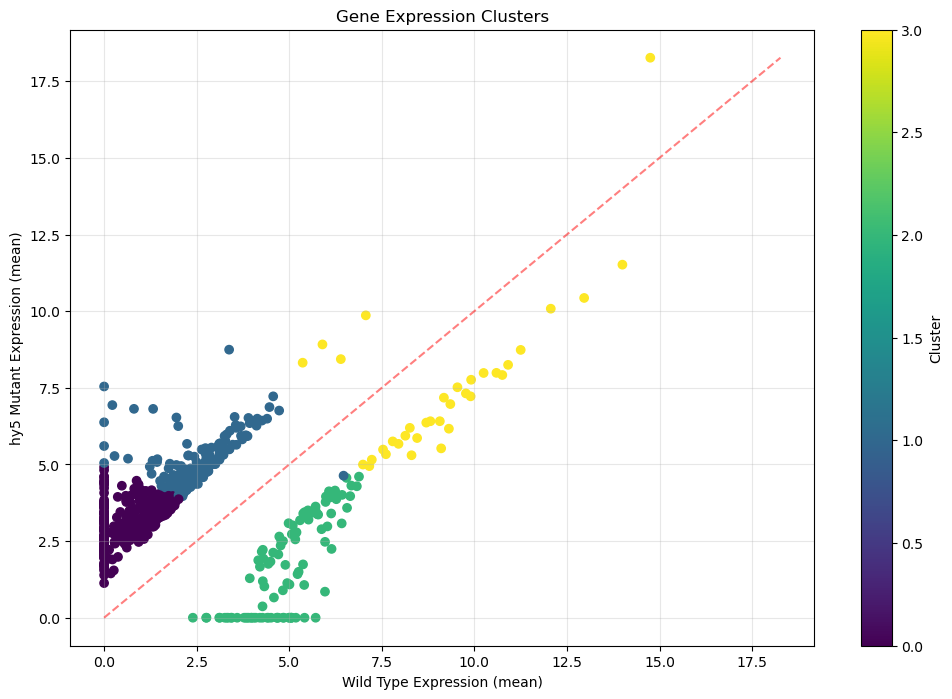

In [7]:
# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(expression_data['WT_mean'], 
                     expression_data['hy5_mean'],
                     c=expression_data['Cluster'], 
                     cmap='viridis')
plt.xlabel('Wild Type Expression (mean)')
plt.ylabel('hy5 Mutant Expression (mean)')
plt.title('Gene Expression Clusters')
plt.colorbar(scatter, label='Cluster')

# Add a diagonal line for reference
min_val = min(expression_data['WT_mean'].min(), expression_data['hy5_mean'].min())
max_val = max(expression_data['WT_mean'].max(), expression_data['hy5_mean'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

plt.grid(True, alpha=0.3)
plt.show()

Looking at this scatter plot of gene expression data, here are the key observations:

Cluster 0 (Purple dots, bottom left):

-   Concentrated in low Wild Type expression (0-2.5 on x-axis)
-   Shows higher expression in hy5 mutant (2-5 on y-axis)
-   Forms a dense cluster above the diagonal red line, indicating consistent upregulation

Cluster 1 (Blue dots, middle):

-   Moderate Wild Type expression (2-5 on x-axis)
-   Consistently higher expression in hy5 mutant (4-7 on y-axis)
-   Sits distinctly above the diagonal, showing clear upregulation

Cluster 2 (Green dots, middle-right):

-   Strong Wild Type expression (5-7.5 on x-axis)
-   Lower expression in hy5 mutant (0-4 on y-axis)
-   Falls below the diagonal line, indicating downregulation

Cluster 3 (Yellow dots, top right):

-   Highest Wild Type expression (7.5-15 on x-axis)
-   Maintains high expression in mutant (5-18 on y-axis)
-   Clusters near the diagonal line, suggesting minimal change

In [8]:
def calculate_cluster_patterns(df, fold_change_threshold=1.5):
    """
    Analyze gene expression patterns for each cluster, providing comprehensive statistics
    about how genes respond to the absence of HY5.
    
    Args:
        df: DataFrame containing gene expression data with WT_mean and hy5_mean columns
        fold_change_threshold: Minimum fold change to consider a gene significantly regulated
        
    Returns:
        Three DataFrames containing basic statistics, expression ratios, and regulation patterns
    """
    # Calculate basic statistics for each cluster
    # We separate WT and hy5 calculations for clarity
    wt_stats = df.groupby('Cluster')['WT_mean'].agg(['mean', 'std', 'count']).round(2)
    hy5_stats = df.groupby('Cluster')['hy5_mean'].agg(['mean', 'std']).round(2)
    
    # Combine statistics into a multi-level column DataFrame
    cluster_stats = pd.concat({
        'WT_mean': wt_stats,
        'hy5_mean': hy5_stats
    }, axis=1)
    
    # Calculate expression ratios with careful handling of low expression values
    def calculate_stable_ratio(group):
        """
        Calculate expression ratios while avoiding division by very small numbers.
        Only considers genes with meaningful WT expression (>0.1) to prevent inflated ratios.
        """
        meaningful_expression = group['WT_mean'] > 0.1
        if meaningful_expression.any():
            ratios = group[meaningful_expression]['hy5_mean'] / group[meaningful_expression]['WT_mean']
            return ratios.mean()
        return 0  # Return 0 if no genes meet the criteria
    
    # Calculate ratios using our stable method
    ratios = df.groupby('Cluster').apply(
        calculate_stable_ratio,
        include_groups=False
    ).round(2)
    
    # Calculate the percentage of genes showing significant regulation
    patterns = pd.DataFrame({
        'Upregulated in hy5': df.groupby('Cluster').apply(
            lambda x: (x['hy5_mean'] > x['WT_mean'] * fold_change_threshold).mean() * 100,
            include_groups=False
        ),
        'Downregulated in hy5': df.groupby('Cluster').apply(
            lambda x: (x['hy5_mean'] < x['WT_mean'] / fold_change_threshold).mean() * 100,
            include_groups=False
        )
    }).round(1)
    
    return cluster_stats, ratios, patterns

# Calculate all statistics
cluster_stats, cluster_ratios, regulation_patterns = calculate_cluster_patterns(expression_data)

# Print results with informative headers
print("Cluster Statistics:")
print("This shows the mean expression, standard deviation, and number of genes in each cluster")
print(cluster_stats)
print("\nAverage hy5/WT expression ratio for each cluster:")
print("(Ratios calculated only for genes with meaningful WT expression)")
print(cluster_ratios)
print("\nRegulation patterns (percentage of genes):")
print("(Shows what fraction of genes are significantly up- or down-regulated)")
print(regulation_patterns)

Cluster Statistics:
This shows the mean expression, standard deviation, and number of genes in each cluster
        WT_mean             hy5_mean      
           mean   std count     mean   std
Cluster                                   
0          0.77  0.64   295     3.18  0.68
1          2.46  0.90   177     5.03  0.83
2          4.96  0.99   105     1.77  1.58
3          9.15  2.13    35     7.49  2.51

Average hy5/WT expression ratio for each cluster:
(Ratios calculated only for genes with meaningful WT expression)
Cluster
0    3.85
1    2.39
2    0.32
3    0.83
dtype: float64

Regulation patterns (percentage of genes):
(Shows what fraction of genes are significantly up- or down-regulated)
         Upregulated in hy5  Downregulated in hy5
Cluster                                          
0                     100.0                   0.0
1                      98.3                   0.0
2                       0.0                  97.1
3                       5.7                   8

Here's a concise summary of the HY5 gene expression clusters in bullet points:

Cluster 0 (295 genes) - Strong Repression:

-   Very low expression with HY5 (0.77), jumps to 3.18 without HY5
-   100% of genes show upregulation in mutant
-   HY5 acts as a strong repressor for these genes

Cluster 1 (177 genes) - Moderate Repression:

-   Moderate expression with HY5 (2.46), increases to 5.03 without HY5
-   98.3% show upregulation in mutant
-   Maintains some baseline expression even with HY5 present

Cluster 2 (105 genes) - HY5-Dependent Activation:

-   Strong expression with HY5 (4.96), drops to 1.77 without HY5
-   97.1% show downregulation in mutant
-   HY5 acts as an activator for these genes

Cluster 3 (35 genes) - HY5-Independent:

-   High expression in both conditions (9.15 → 7.49)
-   Minimal regulation by HY5 (only 5.7% up, 8.6% down)
-   Likely controlled by other regulatory factors

Key takeaway: HY5 can act as either a repressor or activator depending on the target genes, with some genes being largely independent of its control.